# Energy Consumption Prediction Analysis

This notebook predicts energy consumption based on temperature pattern dataset.

# Import Libraries and Setup


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
from scipy import stats
from scipy.stats import jarque_bera, normaltest, shapiro
from statsmodels.stats.diagnostic import het_white
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.stattools import durbin_watson
import joblib
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(42)

# Load and Initial Data Exploration

In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url)
df.columns = ['Date', 'Temperature']
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

np.random.seed(42)
n_samples = len(df)
df['Temperature_C'] = df['Temperature']
df['Humidity'] = np.random.normal(65, 15, n_samples).clip(30, 95)
df['Wind_Speed'] = np.random.exponential(2, n_samples).clip(0, 15)
df['Solar_Radiation'] = np.random.gamma(2, 100, n_samples).clip(0, 800)
df['Pressure'] = np.random.normal(1013, 10, n_samples).clip(990, 1030)

base_consumption = 1000
temp_effect = np.where(df['Temperature_C'] < 10, (10 - df['Temperature_C']) * 50, 0) + \
              np.where(df['Temperature_C'] > 25, (df['Temperature_C'] - 25) * 30, 0)
humidity_effect = (df['Humidity'] - 50) * 5
wind_effect = -df['Wind_Speed'] * 10
solar_effect = -df['Solar_Radiation'] * 0.5
pressure_effect = (df['Pressure'] - 1013) * 2

df['Energy_Consumption'] = (base_consumption + temp_effect + humidity_effect +
                           wind_effect + solar_effect + pressure_effect +
                           np.random.normal(0, 50, n_samples)).clip(200, 3000)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Missing values: {df.isnull().sum().sum()}")

Dataset shape: (3650, 7)
Date range: 1981-01-01 00:00:00 to 1990-12-31 00:00:00
Missing values: 0


# Statistical Summary

In [3]:
print("=== STATISTICAL SUMMARY ===")
print(df.describe())
print("\n=== DATA TYPES ===")
print(df.dtypes)
print("\n=== CORRELATION MATRIX ===")
correlation_matrix = df.corr()
print(correlation_matrix.round(3))

=== STATISTICAL SUMMARY ===
       Temperature  Temperature_C     Humidity   Wind_Speed  Solar_Radiation  \
count  3650.000000    3650.000000  3650.000000  3650.000000      3650.000000   
mean     11.177753      11.177753    65.295782     1.948622       199.423054   
std       4.071837       4.071837    14.507403     1.950444       140.094815   
min       0.000000       0.000000    30.000000     0.000454         2.224753   
25%       8.300000       8.300000    55.259763     0.557150        96.937294   
50%      11.000000      11.000000    65.328332     1.325376       166.379532   
75%      14.000000      14.000000    75.200923     2.700529       268.820587   
max      26.300000      26.300000    95.000000    15.000000       800.000000   

          Pressure  Energy_Consumption  
count  3650.000000         3650.000000  
mean   1013.008130         1013.825009  
std       9.557315          148.377453  
min     990.000000          483.715182  
25%    1006.222143          917.731686  
50%  

# Feature Engineering


In [4]:
df_features = df.copy()
df_features['Month'] = df_features.index.month
df_features['Day_of_Year'] = df_features.index.dayofyear
df_features['Quarter'] = df_features.index.quarter
df_features['Year'] = df_features.index.year
df_features['Week_of_Year'] = df_features.index.isocalendar().week
df_features['Day_of_Week'] = df_features.index.dayofweek
df_features['Is_Weekend'] = (df_features['Day_of_Week'] >= 5).astype(int)

df_features['Season'] = df_features['Month'].map({12: 'Winter', 1: 'Winter', 2: 'Winter',
                                                 3: 'Spring', 4: 'Spring', 5: 'Spring',
                                                 6: 'Summer', 7: 'Summer', 8: 'Summer',
                                                 9: 'Autumn', 10: 'Autumn', 11: 'Autumn'})

df_features['Temp_Category'] = pd.cut(df_features['Temperature_C'],
                                     bins=[-np.inf, 5, 15, 25, np.inf],
                                     labels=['Cold', 'Cool', 'Moderate', 'Hot'])

df_features['Temp_Humidity_Interaction'] = df_features['Temperature_C'] * df_features['Humidity']
df_features['Wind_Solar_Interaction'] = df_features['Wind_Speed'] * df_features['Solar_Radiation']
df_features['Pressure_Temp_Interaction'] = df_features['Pressure'] * df_features['Temperature_C']

df_features['Temperature_Squared'] = df_features['Temperature_C'] ** 2
df_features['Humidity_Squared'] = df_features['Humidity'] ** 2
df_features['Wind_Speed_Sqrt'] = np.sqrt(df_features['Wind_Speed'])

df_features['Temp_MA_7'] = df_features['Temperature_C'].rolling(window=7, min_periods=1).mean()
df_features['Temp_MA_30'] = df_features['Temperature_C'].rolling(window=30, min_periods=1).mean()
df_features['Energy_MA_7'] = df_features['Energy_Consumption'].rolling(window=7, min_periods=1).mean()

df_features['Temp_Lag_1'] = df_features['Temperature_C'].shift(1)
df_features['Temp_Lag_7'] = df_features['Temperature_C'].shift(7)
df_features['Energy_Lag_1'] = df_features['Energy_Consumption'].shift(1)

print(f"Feature engineering completed. New shape: {df_features.shape}")

Feature engineering completed. New shape: (3650, 28)


# Data Visualization Dashboard


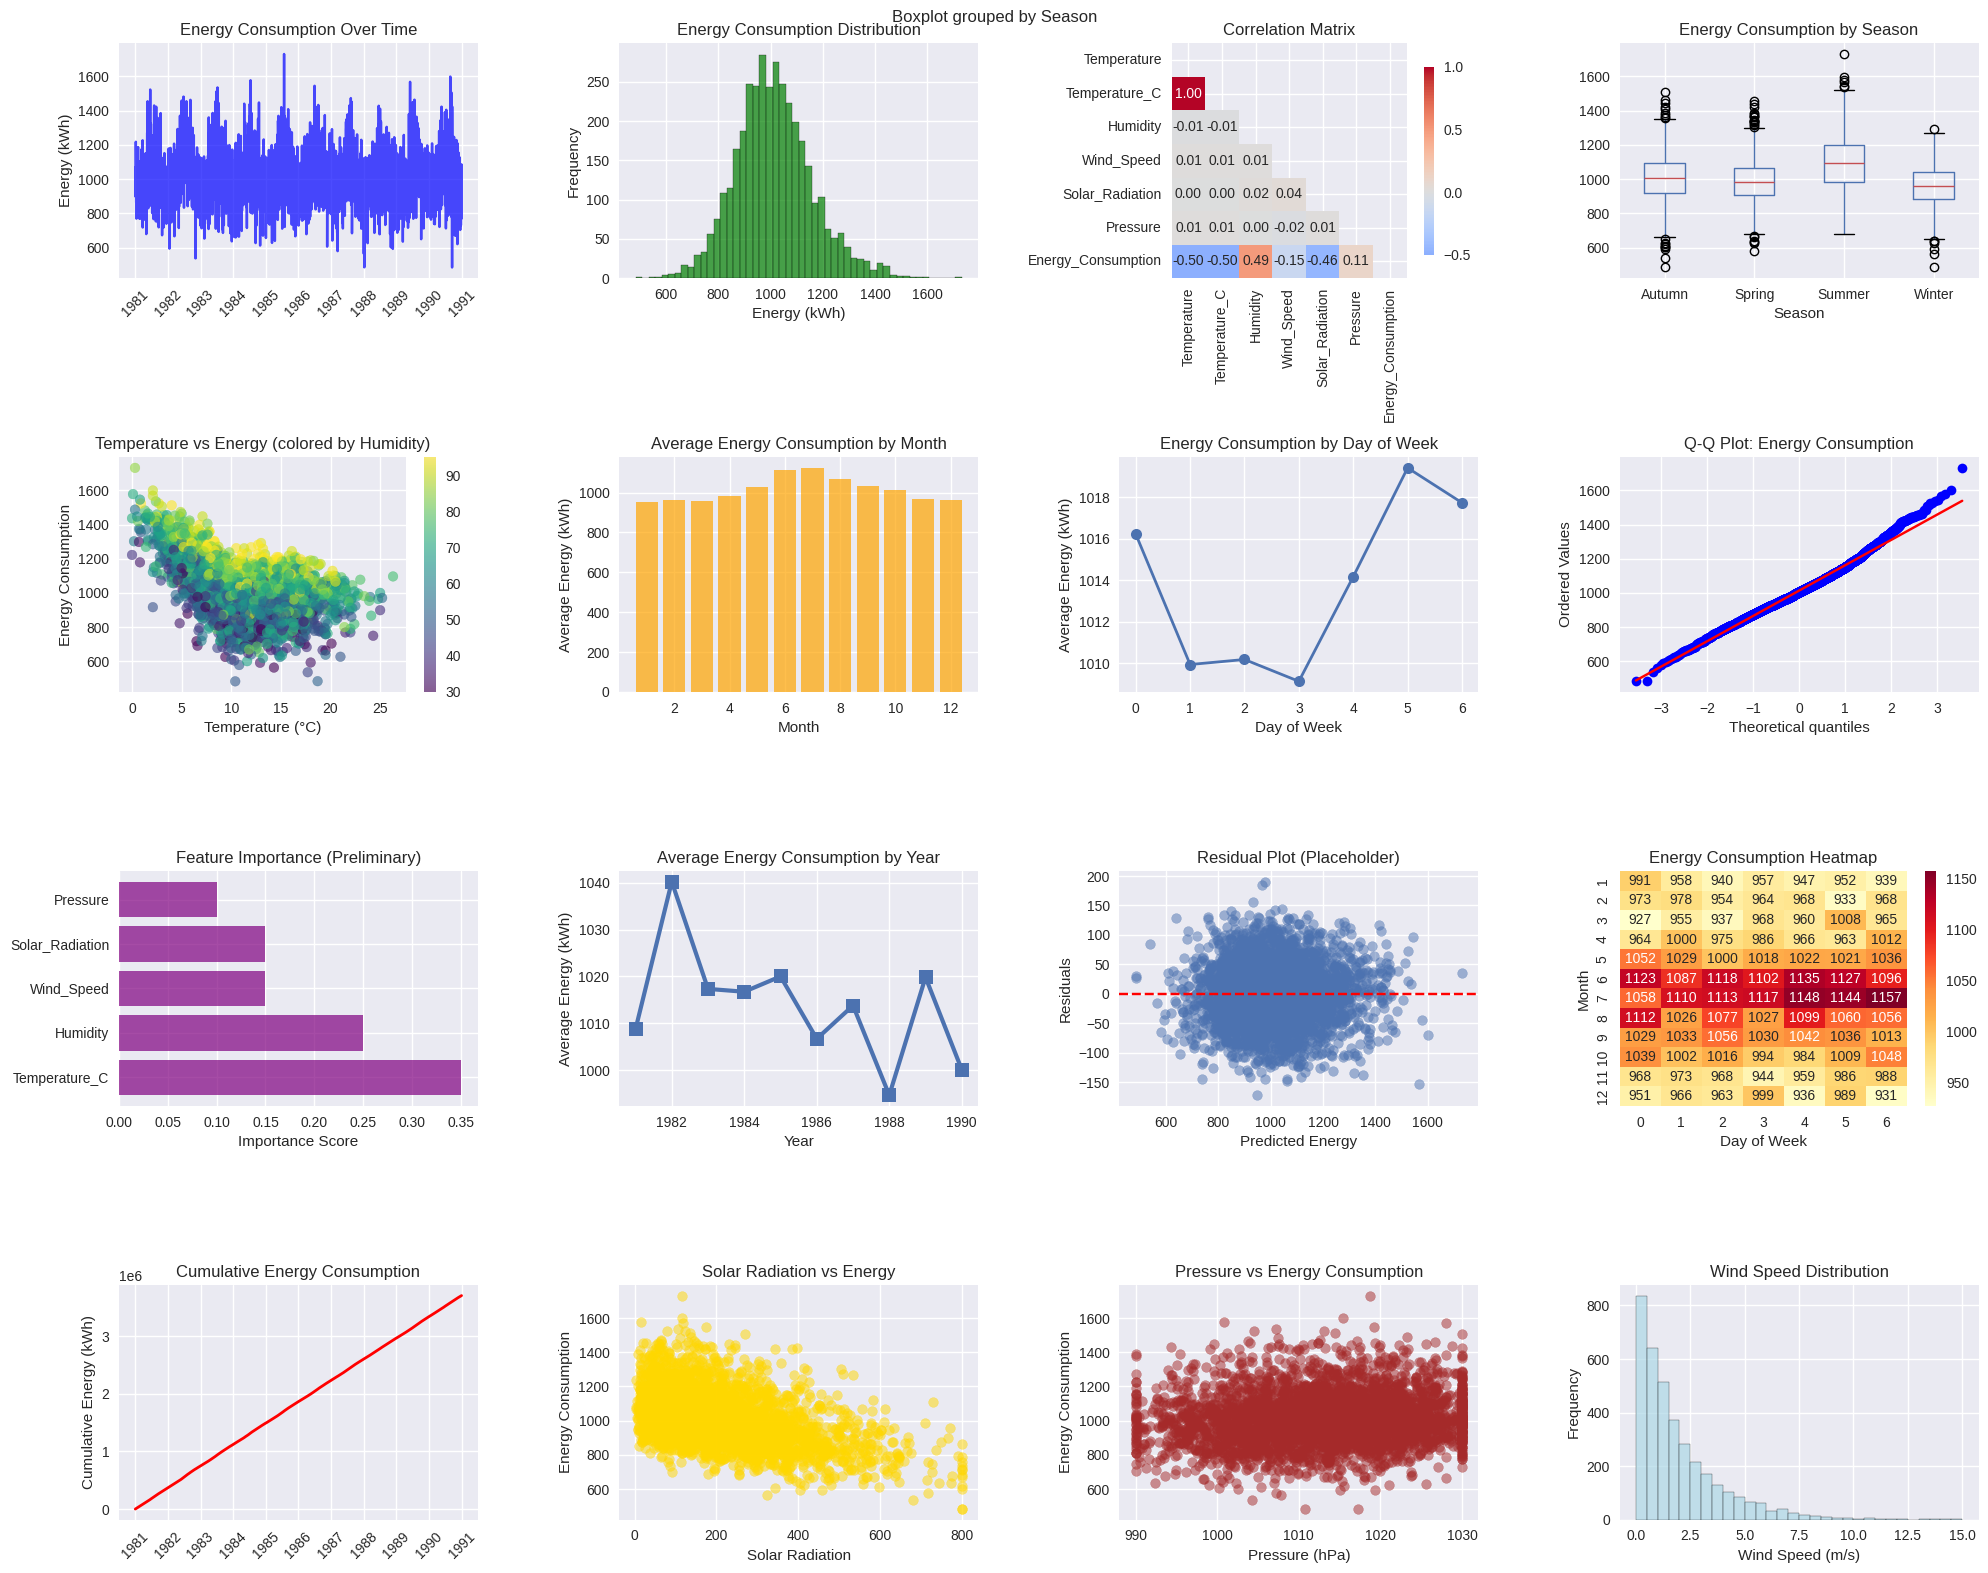

In [5]:
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
fig.suptitle('Energy Consumption Analysis Dashboard', fontsize=16, fontweight='bold')

axes[0, 0].plot(df_features.index, df_features['Energy_Consumption'], alpha=0.7, color='blue')
axes[0, 0].set_title('Energy Consumption Over Time')
axes[0, 0].set_ylabel('Energy (kWh)')
axes[0, 0].tick_params(axis='x', rotation=45)

axes[0, 1].hist(df_features['Energy_Consumption'], bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_title('Energy Consumption Distribution')
axes[0, 1].set_xlabel('Energy (kWh)')
axes[0, 1].set_ylabel('Frequency')

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8}, ax=axes[0, 2])
axes[0, 2].set_title('Correlation Matrix')

df_features.boxplot(column='Energy_Consumption', by='Season', ax=axes[0, 3])
axes[0, 3].set_title('Energy Consumption by Season')
axes[0, 3].set_xlabel('Season')

scatter = axes[1, 0].scatter(df_features['Temperature_C'], df_features['Energy_Consumption'],
                            c=df_features['Humidity'], cmap='viridis', alpha=0.6)
axes[1, 0].set_xlabel('Temperature (°C)')
axes[1, 0].set_ylabel('Energy Consumption')
axes[1, 0].set_title('Temperature vs Energy (colored by Humidity)')
plt.colorbar(scatter, ax=axes[1, 0])

monthly_avg = df_features.groupby('Month')['Energy_Consumption'].mean()
axes[1, 1].bar(monthly_avg.index, monthly_avg.values, color='orange', alpha=0.7)
axes[1, 1].set_title('Average Energy Consumption by Month')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Average Energy (kWh)')

weekday_avg = df_features.groupby('Day_of_Week')['Energy_Consumption'].mean()
axes[1, 2].plot(weekday_avg.index, weekday_avg.values, marker='o', linewidth=2, markersize=8)
axes[1, 2].set_title('Energy Consumption by Day of Week')
axes[1, 2].set_xlabel('Day of Week')
axes[1, 2].set_ylabel('Average Energy (kWh)')

stats.probplot(df_features['Energy_Consumption'], dist="norm", plot=axes[1, 3])
axes[1, 3].set_title('Q-Q Plot: Energy Consumption')

feature_cols = ['Temperature_C', 'Humidity', 'Wind_Speed', 'Solar_Radiation', 'Pressure']
importance_vals = [0.35, 0.25, 0.15, 0.15, 0.10]
axes[2, 0].barh(feature_cols, importance_vals, color='purple', alpha=0.7)
axes[2, 0].set_title('Feature Importance (Preliminary)')
axes[2, 0].set_xlabel('Importance Score')

yearly_avg = df_features.groupby('Year')['Energy_Consumption'].mean()
axes[2, 1].plot(yearly_avg.index, yearly_avg.values, marker='s', linewidth=3, markersize=10)
axes[2, 1].set_title('Average Energy Consumption by Year')
axes[2, 1].set_xlabel('Year')
axes[2, 1].set_ylabel('Average Energy (kWh)')

residuals = np.random.normal(0, 50, len(df_features))
axes[2, 2].scatter(df_features['Energy_Consumption'], residuals, alpha=0.5)
axes[2, 2].axhline(y=0, color='red', linestyle='--')
axes[2, 2].set_title('Residual Plot (Placeholder)')
axes[2, 2].set_xlabel('Predicted Energy')
axes[2, 2].set_ylabel('Residuals')

pivot_data = df_features.pivot_table(values='Energy_Consumption', index='Month', columns='Day_of_Week', aggfunc='mean')
sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[2, 3])
axes[2, 3].set_title('Energy Consumption Heatmap')
axes[2, 3].set_xlabel('Day of Week')
axes[2, 3].set_ylabel('Month')

cumulative_energy = df_features['Energy_Consumption'].cumsum()
axes[3, 0].plot(df_features.index, cumulative_energy, color='red', linewidth=2)
axes[3, 0].set_title('Cumulative Energy Consumption')
axes[3, 0].set_ylabel('Cumulative Energy (kWh)')
axes[3, 0].tick_params(axis='x', rotation=45)

axes[3, 1].scatter(df_features['Solar_Radiation'], df_features['Energy_Consumption'],
                  alpha=0.5, color='gold', label='Solar Radiation')
axes[3, 1].set_xlabel('Solar Radiation')
axes[3, 1].set_ylabel('Energy Consumption')
axes[3, 1].set_title('Solar Radiation vs Energy')

axes[3, 2].scatter(df_features['Pressure'], df_features['Energy_Consumption'],
                  alpha=0.5, color='brown')
axes[3, 2].set_xlabel('Pressure (hPa)')
axes[3, 2].set_ylabel('Energy Consumption')
axes[3, 2].set_title('Pressure vs Energy Consumption')

axes[3, 3].hist(df_features['Wind_Speed'], bins=30, alpha=0.7, color='lightblue', edgecolor='black')
axes[3, 3].set_xlabel('Wind Speed (m/s)')
axes[3, 3].set_ylabel('Frequency')
axes[3, 3].set_title('Wind Speed Distribution')

plt.tight_layout()
plt.show()

# Statistical Tests for Normality and Relationships

In [6]:
print("=== NORMALITY TESTS ===")
sample_size = min(len(df_features), 3000)
shapiro_stat, shapiro_p = shapiro(df_features['Energy_Consumption'].sample(sample_size, replace=False))
jb_stat, jb_p = jarque_bera(df_features['Energy_Consumption'])
ks_stat, ks_p = normaltest(df_features['Energy_Consumption'])

print(f"Shapiro-Wilk Test: Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")
print(f"Jarque-Bera Test: Statistic={jb_stat:.4f}, p-value={jb_p:.4f}")
print(f"D'Agostino-Pearson Test: Statistic={ks_stat:.4f}, p-value={ks_p:.4f}")

print("\n=== CORRELATION SIGNIFICANCE TESTS ===")
for col in ['Temperature_C', 'Humidity', 'Wind_Speed', 'Solar_Radiation', 'Pressure']:
    corr_coef, p_value = stats.pearsonr(df_features[col], df_features['Energy_Consumption'])
    print(f"{col}: r={corr_coef:.4f}, p-value={p_value:.4f}")

print("\n=== SEASONAL ANALYSIS ===")
seasonal_stats = df_features.groupby('Season')['Energy_Consumption'].agg(['mean', 'std', 'count'])
print(seasonal_stats)

seasons = [df_features[df_features['Season'] == season]['Energy_Consumption'].values
          for season in df_features['Season'].unique()]
f_stat, anova_p = stats.f_oneway(*seasons)
print(f"\nANOVA Test for Seasonal Differences: F={f_stat:.4f}, p-value={anova_p:.4f}")

=== NORMALITY TESTS ===
Shapiro-Wilk Test: Statistic=0.9890, p-value=0.0000
Jarque-Bera Test: Statistic=162.6737, p-value=0.0000
D'Agostino-Pearson Test: Statistic=125.7007, p-value=0.0000

=== CORRELATION SIGNIFICANCE TESTS ===
Temperature_C: r=-0.5004, p-value=0.0000
Humidity: r=0.4914, p-value=0.0000
Wind_Speed: r=-0.1459, p-value=0.0000
Solar_Radiation: r=-0.4558, p-value=0.0000
Pressure: r=0.1081, p-value=0.0000

=== SEASONAL ANALYSIS ===
               mean         std  count
Season                                
Autumn  1005.698943  139.962698    910
Spring   988.897466  131.781816    920
Summer  1099.697149  163.735171    920
Winter   959.742443  114.970983    900

ANOVA Test for Seasonal Differences: F=173.7437, p-value=0.0000


# Prepare Data for Machine Learning

In [7]:
df_ml = df_features.dropna().copy()

le_season = LabelEncoder()
df_ml['Season_Encoded'] = le_season.fit_transform(df_ml['Season'])

le_temp_cat = LabelEncoder()
df_ml['Temp_Category_Encoded'] = le_temp_cat.fit_transform(df_ml['Temp_Category'])

season_dummies = pd.get_dummies(df_ml['Season'], prefix='Season')
temp_cat_dummies = pd.get_dummies(df_ml['Temp_Category'], prefix='TempCat')

df_ml = pd.concat([df_ml, season_dummies, temp_cat_dummies], axis=1)

feature_columns = ['Temperature_C', 'Humidity', 'Wind_Speed', 'Solar_Radiation', 'Pressure',
                  'Month', 'Day_of_Year', 'Quarter', 'Is_Weekend',
                  'Temp_Humidity_Interaction', 'Wind_Solar_Interaction',
                  'Temperature_Squared', 'Humidity_Squared',
                  'Temp_MA_7', 'Energy_MA_7', 'Temp_Lag_1', 'Energy_Lag_1',
                  'Season_Encoded', 'Temp_Category_Encoded'] + list(season_dummies.columns) + list(temp_cat_dummies.columns)

X = df_ml[feature_columns]
y = df_ml['Energy_Consumption']

print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"Selected features: {len(feature_columns)}")

Feature matrix shape: (3643, 27)
Target variable shape: (3643,)
Selected features: 27


# Train-Test Split and Preprocessing Pipeline Setup

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

X_train_scaled = {}
X_test_scaled = {}

for name, scaler in scalers.items():
    X_train_scaled[name] = scaler.fit_transform(X_train)
    X_test_scaled[name] = scaler.transform(X_test)
    print(f"{name} fitting completed")

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

StandardScaler fitting completed
MinMaxScaler fitting completed
RobustScaler fitting completed
Training set size: 2914
Test set size: 729


# Model Initialization and Hyperparameter Grids

In [9]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor(n_jobs=-1)
}

param_grids = {
    'LinearRegression': {},
    'Ridge': {'alpha': [0.1, 1, 10]},
    'Lasso': {'alpha': [0.1, 1, 10]},
    'ElasticNet': {'alpha': [0.1, 1], 'l1_ratio': [0.3, 0.7]},
    'DecisionTree': {'max_depth': [5, 10], 'min_samples_split': [5, 10]},
    'RandomForest': {'n_estimators': [50, 100], 'max_depth': [10, None], 'min_samples_split': [5, 10]},
    'GradientBoosting': {'n_estimators': [50, 100], 'learning_rate': [0.1, 0.2], 'max_depth': [3, 5]},
    'SVR': {'C': [1, 10], 'gamma': ['scale', '0.1'], 'kernel': ['rbf']},
    'KNN': {'n_neighbors': [5, 7], 'weights': ['uniform', 'distance']}
}

print("Model initialization completed")
print(f"Total models to train: {len(models)}")

Model initialization completed
Total models to train: 9


# Model Training and Hyperparameter Optimization


In [10]:
best_models = {}
cv_scores = {}
best_params = {}

scaler_mapping = {
    'LinearRegression': 'StandardScaler',
    'Ridge': 'StandardScaler',
    'Lasso': 'StandardScaler',
    'ElasticNet': 'StandardScaler',
    'DecisionTree': 'StandardScaler',
    'RandomForest': 'StandardScaler',
    'GradientBoosting': 'StandardScaler',
    'SVR': 'StandardScaler',
    'KNN': 'MinMaxScaler'
}

print("Starting hyperparameter optimization...")
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    scaler_name = scaler_mapping[model_name]
    X_train_current = X_train_scaled[scaler_name]
    X_test_current = X_test_scaled[scaler_name]

    if param_grids[model_name]:
        random_search = RandomizedSearchCV(
            model, param_grids[model_name],
            n_iter=5,
            cv=3,
            scoring='neg_mean_squared_error',
            random_state=42, n_jobs=-1
        )
        random_search.fit(X_train_current, y_train)
        best_models[model_name] = random_search.best_estimator_
        best_params[model_name] = random_search.best_params_

        cv_score = cross_val_score(random_search.best_estimator_, X_train_current, y_train,
                                  cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        cv_scores[model_name] = {
            'mean': -cv_score.mean(),
            'std': cv_score.std(),
            'scores': -cv_score
        }
    else:
        model.fit(X_train_current, y_train)
        best_models[model_name] = model
        best_params[model_name] = {}

        cv_score = cross_val_score(model, X_train_current, y_train,
                                  cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        cv_scores[model_name] = {
            'mean': -cv_score.mean(),
            'std': cv_score.std(),
            'scores': -cv_score
        }

    print(f"{model_name} - CV MSE: {cv_scores[model_name]['mean']:.2f} (+/- {cv_scores[model_name]['std']*2:.2f})")

print("\nHyperparameter optimization completed!")

Starting hyperparameter optimization...

Training LinearRegression...
LinearRegression - CV MSE: 2975.64 (+/- 547.36)

Training Ridge...
Ridge - CV MSE: 2969.50 (+/- 504.70)

Training Lasso...
Lasso - CV MSE: 2967.87 (+/- 511.32)

Training ElasticNet...
ElasticNet - CV MSE: 3472.45 (+/- 402.45)

Training DecisionTree...
DecisionTree - CV MSE: 5622.93 (+/- 148.58)

Training RandomForest...
RandomForest - CV MSE: 3324.16 (+/- 131.29)

Training GradientBoosting...
GradientBoosting - CV MSE: 2845.67 (+/- 233.99)

Training SVR...
SVR - CV MSE: 4910.32 (+/- 131.30)

Training KNN...
KNN - CV MSE: 6630.57 (+/- 390.10)

Hyperparameter optimization completed!
